> ### Problem: Adversarial Noise (from the author's description)
>The task involves developing a program that manipulates images by adding adversarial noise. This noise is designed to trick an image classification model into misclassifying the altered image as a specified target class, regardless of the original content.
> - You may select any pre-trained image classification model for this task. A model from the torchvision library is recommended, but not mandatory.
> - The core challenge is to effectively introduce noise into the image in such a way that the model misclassifies it as the desired target class, without making the noise perceptible to a casual human viewer.





### 0.1 Getting Started

The goal of the challenge is to develop a program that adds adversarial noise to images with the aim of tricking an image classification model without being detected by a human. 

More formally, consider that $\mathcal{D} = \{ (x_i, y_i) \}_{i=1}^N$ is a dataset of images and their corresponding labels. Let also $f_{\theta}: \mathcal{X} \to \mathcal{Y}$ be a pre-trained image classification model with estimated parameters $\theta$, where $\mathcal{X}$ is the space of images and $\mathcal{Y}$ is the space of labels that achieves $a%$ accuracy a dataset. The goal is to find an adversarial noise $\epsilon$ such that the model misclassifies the image $x_i$:

$$
\epsilon^* = \arg\min_{\epsilon} \frac{1}{N} \sum_{i=1}^N \mathbb{I}\Big(f_{\theta}(x_i + \epsilon) = y_i\Big)
$$

Thus, we have the following model components:

1. **Dataset**: A collection of images and their corresponding labels.
2. **Model**: A pre-trained image classification model that can be used to classify images.
3. **Adversarial Noise**: A perturbation that can be added to the images

This will guide the development of the solution thorough this notebook.

### 0.2 Dataset

The dataset used in this challenge is the 
[Tiny ImageNet]("https://www.kaggle.com/c/tiny-imagenet") dataset, which is a subset of the full ImageNet dataset designed for faster experimentation and academic research. 
Tiny ImageNet contains 200 classes, each corresponding to a WordNet ID (WNID), with 500 training images per class.

The images are color images of size 64×64 pixels, significantly smaller than the 
original ImageNet 224×224 images, making it more manageable for limited compute resources.

The dataset is organized as follows:
- **Training set:** 100,000 images (500 images × 200 classes)
- **Validation set:** 10,000 images (50 images × 200 classes)
- **Test set:** 10,000 images (50 images × 200 classes, labels withheld)

Each class folder contains an <code>images/</code> directory with the raw images and an <code>annotation.txt</code> file describing bounding boxes for the objects. Class code (WNIDs) can be mapped to human-readable class names using the provided <code>words.txt</code> file.

We start by visualizing a few sample images from the dataset to better understand its characteristics and diversity.

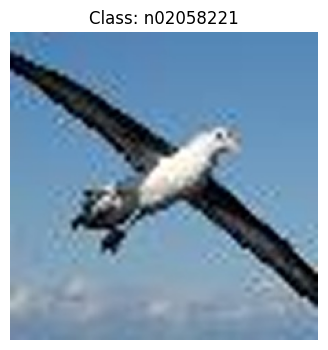

In [2]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# --- Path to Tiny ImageNet 224 ---
data_path = os.path.join(os.getcwd(), "data", "inputs", "tiny-224")

# --- Train folder ---
train_path = os.path.join(data_path, "train")

# --- Get all class directories ---
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# --- Pick a random class and a random image ---
random.seed(19940202)
random_class = random.choice(classes)
images_dir = os.path.join(train_path, random_class, "images")  # folder structure: train/WNID/images
image_files = os.listdir(images_dir)
random_image_file = random.choice(image_files)
image_path = os.path.join(images_dir, random_image_file)

# --- Load and display the image ---
img = Image.open(image_path).convert("RGB")

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Class: {random_class}")
plt.axis('off')
plt.show()

Below we have the description of each of the classes of the tiny imagenet dataset:

In [3]:
import os

# --- Path to Tiny ImageNet 224 root folder ---
data_path = os.path.join(os.getcwd(), "data")

# --- Load WordNet ID to human-readable label mapping ---
words_path = os.path.join(data_path, "utils", "words.txt")
id_to_label = {}

with open(words_path, 'r') as f:
    for line in f:
        wnid, label = line.strip().split('\t')
        id_to_label[wnid] = label

# --- Get classes directly from train folder ---
train_path = os.path.join(data_path, "inputs", "tiny-224", "train")
wnids = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])

# --- Print mapping for all classes ---
print(f"Total classes: {len(wnids)}\n")
for wnid in wnids:
    human_label = id_to_label.get(wnid, "Unknown class")
    print(f"{wnid} -> {human_label}")


Total classes: 200

n01443537 -> goldfish, Carassius auratus
n01629819 -> European fire salamander, Salamandra salamandra
n01641577 -> bullfrog, Rana catesbeiana
n01644900 -> tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
n01698640 -> American alligator, Alligator mississipiensis
n01742172 -> boa constrictor, Constrictor constrictor
n01768244 -> trilobite
n01770393 -> scorpion
n01774384 -> black widow, Latrodectus mactans
n01774750 -> tarantula
n01784675 -> centipede
n01855672 -> goose
n01882714 -> koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
n01910747 -> jellyfish
n01917289 -> brain coral
n01944390 -> snail
n01945685 -> slug
n01950731 -> sea slug, nudibranch
n01983481 -> American lobster, Northern lobster, Maine lobster, Homarus americanus
n01984695 -> spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
n02002724 -> black stork, Ciconia nigra
n02056570 -> king penguin, Aptenodytes patagonica
n02058221 -> albatross, mollyma

### 0.3 Pre-Trained Model

For this challenge, we leverage ImageNet pre-trained models, which are trained on 1,000 object classes from the ImageNet dataset (over 14 million images). These models achieve around 70–80% accuracy on the ImageNet test set.

Although they are not state-of-the-art, they provide an excellent starting point because:

- They learn general visual features that transfer well to new tasks.
- They reduce training time and computational cost via transfer learning.
- They can be fine-tuned on specific tasks with limited data.
- They offer strong baseline performance for image recognition experiments.

This makes them well-suited for the initial phase of the task at hand, before considering more advanced architectures. Among the models we evaluated (AlexNet, ResNet64, and ResNet101) we chose ResNet101 for our experiments due to its superior performance and deeper architecture, which consistently achieved higher accuracy on our Tiny ImageNet evaluation.

Because Tiny ImageNet is a 200-class subset of the original 1,000-class ImageNet dataset, predictions from a pre-trained model must be mapped to the Tiny ImageNet label space before evaluation. Each model output corresponds to an ImageNet 1K index, which can be converted to its WordNet ID (WNID) using the <code>imagenet_class_index.json</code> mapping. Tiny ImageNet labels are also defined using WNIDs, so we align predictions by matching the predicted ImageNet WNID to its corresponding Tiny ImageNet class index (0–199). This ensures that both predictions and ground-truth labels share the same label space for computing accuracy.

In [4]:
from torchvision import models, transforms

dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm

# relevant path for the test dataset
test_path = os.path.join(data_path, "inputs", "tiny-224", "test")

# define transformations of the images
transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   

])

# load the test dataset and create a batch loader
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# load pretrained ResNet101 (1,000 classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT).to(device)

# prediction loop
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Pre-trained Model...", unit="batch"):
        images = images.to(device)
        outputs = model(images)

        # imagenet indices (0-999)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# remove samples whose class is not in imagenet 1k
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# load imagenet 1k class index mapping
import json
src_file = os.path.join(data_path, "utils", "imagenet_class_index.json")
with open(src_file, 'r') as f:
    imagenet_class_idx = json.load(f)
tiny_imagenet_class_idx = test_dataset.class_to_idx

# map tiny imagenet classes to imagenet WNIDs
new_target = []
new_preds = []
for pred_idx, gt_idx in zip(all_preds, all_targets):
    # map predicted label (0–999) to WNID
    pred_wnid = imagenet_class_idx[str(pred_idx)][0]
    
    # map GT Tiny ImageNet label (already 0–199) to WNID
    gt_wnid = list(tiny_imagenet_class_idx.keys())[gt_idx]
    
    # only keep if pred is in Tiny ImageNet classes
    if pred_wnid in tiny_imagenet_class_idx:
        new_preds.append(tiny_imagenet_class_idx[pred_wnid])
        new_target.append(tiny_imagenet_class_idx[gt_wnid])

new_preds = np.array(new_preds)
new_target = np.array(new_target)

acc = (new_preds == new_target).mean()
print(f"Test accuracy: {acc*100:.2f}%")

Evaluating Pre-trained Model...: 100%|██████████| 157/157 [00:22<00:00,  6.88batch/s]

Test accuracy: 86.20%


### 1.1 Adversarial Noise: Gaussian Noise to Random Pixels

The first method to introduce adversarial perturbations applies Gaussian noise to a fixed number of randomly selected pixels in the image. This approach is simple yet effective for testing the model’s robustness to localized corruption.

The procedure is as follows:

- Randomly select a set of pixel coordinates across the image.

- For each selected pixel, add Gaussian noise sampled from $\mathcal{N}(0, \sigma^2)$ to all its color channels.

- Optionally clip the resulting values to the valid image range (e.g., $[0,1]$ for normalized images).

This method is non-targeted and does not exploit model gradients, but it simulates visual corruption that can degrade classifier performance. It serves as a baseline adversarial noise approach before applying more sophisticated attacks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


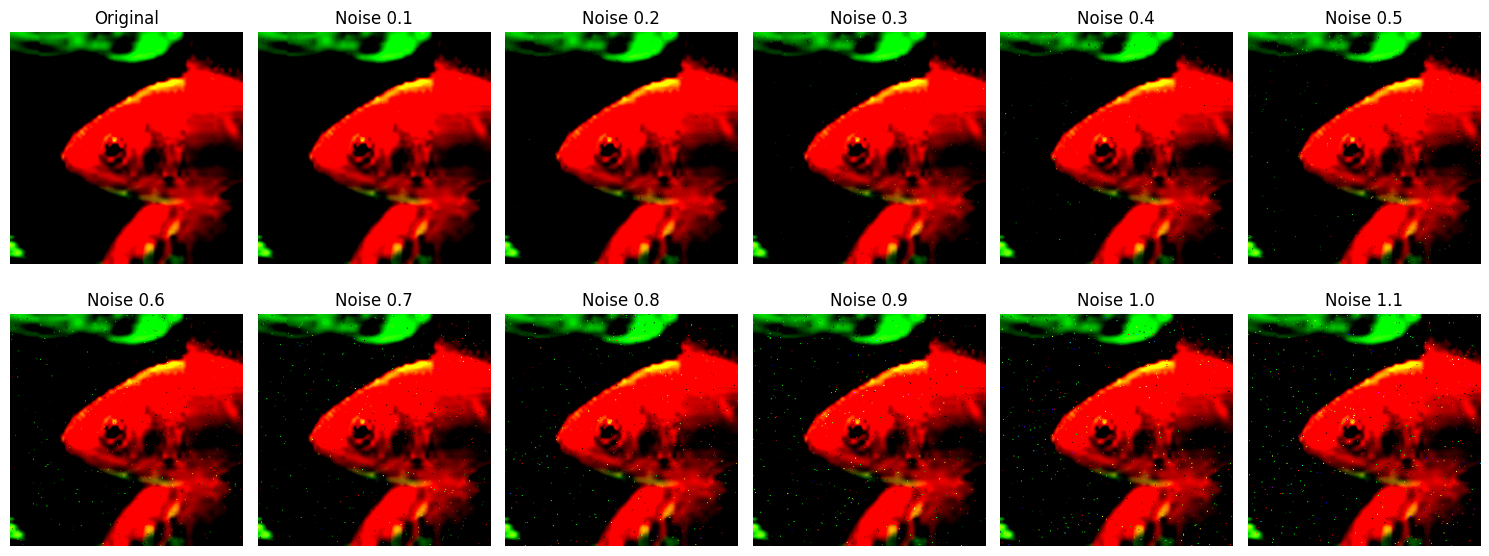

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader

def add_noise_to_random_pixels(image, num_noise_pixels=1000, noise_std=0.1):
    """
    Adds Gaussian noise to `num_noise_pixels` randomly selected pixels in the input image.
    
    Parameters:
    - image: numpy array of shape (H, W, C), values in [0, 1]
    - num_noise_pixels: number of pixels to alter
    - noise_std: standard deviation of the Gaussian noise
    
    Returns:
    - noisy_image: the image with noise added
    """
    H, W, C = image.shape
    noisy_image = image.copy()

    # Select random pixel locations
    pixel_indices = np.random.choice(H * W, size=num_noise_pixels, replace=False)
    rows = pixel_indices // W
    cols = pixel_indices % W

    # Add noise to each pixel across all 3 channels
    noisy_image[rows, cols, :] += np.random.normal(0, noise_std, size=(num_noise_pixels, C))

    # Optional: clip to valid range if needed (e.g., [0, 1] for image display)
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image

# --- Load test dataset and create DataLoader ---
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(test_loader))
i = 1

# Convert the i-th image to (H, W, C) format and to numpy
orig_image = images[i].permute(1, 2, 0).numpy()

# Plot original + noisy versions
noise_levels = np.arange(0.1, 1.2, 0.1)  # 0.1 to 1.0 inclusive
num_levels = len(noise_levels)

plt.figure(figsize=(15, 6))

# Plot original
plt.subplot(2, 6, 1)
plt.imshow(orig_image)
plt.title("Original")
plt.axis('off')

# Plot noisy images
for idx, noise_std in enumerate(noise_levels, start=2):
    noise_image = add_noise_to_random_pixels(orig_image, num_noise_pixels=1000, noise_std=noise_std)
    plt.subplot(2, 6, idx)
    plt.imshow(noise_image)
    plt.title(f"Noise {noise_std:.1f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


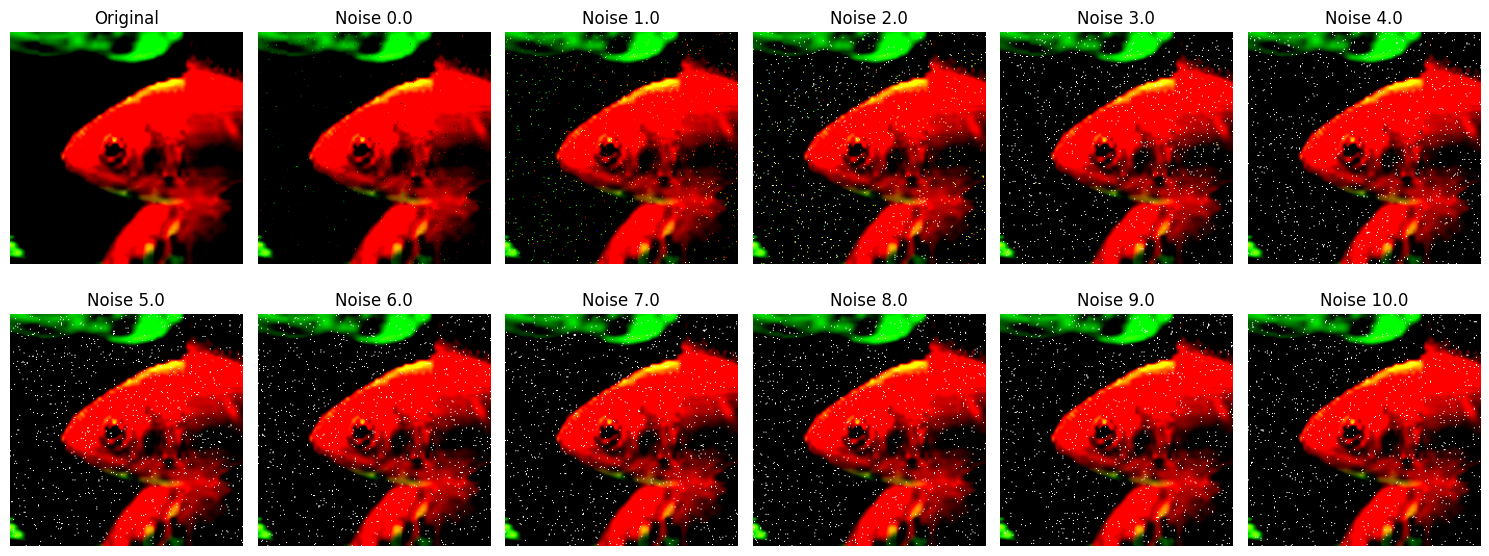

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader

def add_noise_to_random_pixels(image, num_noise_pixels=1000, noise_mean=0, noise_std=0.1):
    """
    Adds Gaussian noise to `num_noise_pixels` randomly selected pixels in the input image.
    
    Parameters:
    - image: numpy array of shape (H, W, C), values in [0, 1]
    - num_noise_pixels: number of pixels to alter
    - noise_std: standard deviation of the Gaussian noise
    
    Returns:
    - noisy_image: the image with noise added
    """
    H, W, C = image.shape
    noisy_image = image.copy()

    # Select random pixel locations
    pixel_indices = np.random.choice(H * W, size=num_noise_pixels, replace=False)
    rows = pixel_indices // W
    cols = pixel_indices % W

    # Add noise to each pixel across all 3 channels
    noisy_image[rows, cols, :] += np.random.normal(noise_mean, noise_std, size=(num_noise_pixels, C))

    # Optional: clip to valid range if needed (e.g., [0, 1] for image display)
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image

# --- Load test dataset and create DataLoader ---
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(test_loader))
i = 1

# Convert the i-th image to (H, W, C) format and to numpy
orig_image = images[i].permute(1, 2, 0).numpy()

# Plot original + noisy versions
# noise_levels = np.arange(0.1, 1.2, 0.1)  # 0.1 to 1.0 inclusive
noise_levels = np.arange(0, 11, 1)  # 0.1 to 1.0 inclusive
num_levels = len(noise_levels)

plt.figure(figsize=(15, 6))

# Plot original
plt.subplot(2, 6, 1)
plt.imshow(orig_image)
plt.title("Original")
plt.axis('off')

# Plot noisy images
for idx, noise_mean in enumerate(noise_levels, start=2):
    noise_image = add_noise_to_random_pixels(orig_image, num_noise_pixels=1000, noise_mean=noise_mean, noise_std=0.5)
    plt.subplot(2, 6, idx)
    plt.imshow(noise_image)
    plt.title(f"Noise {noise_mean:.1f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


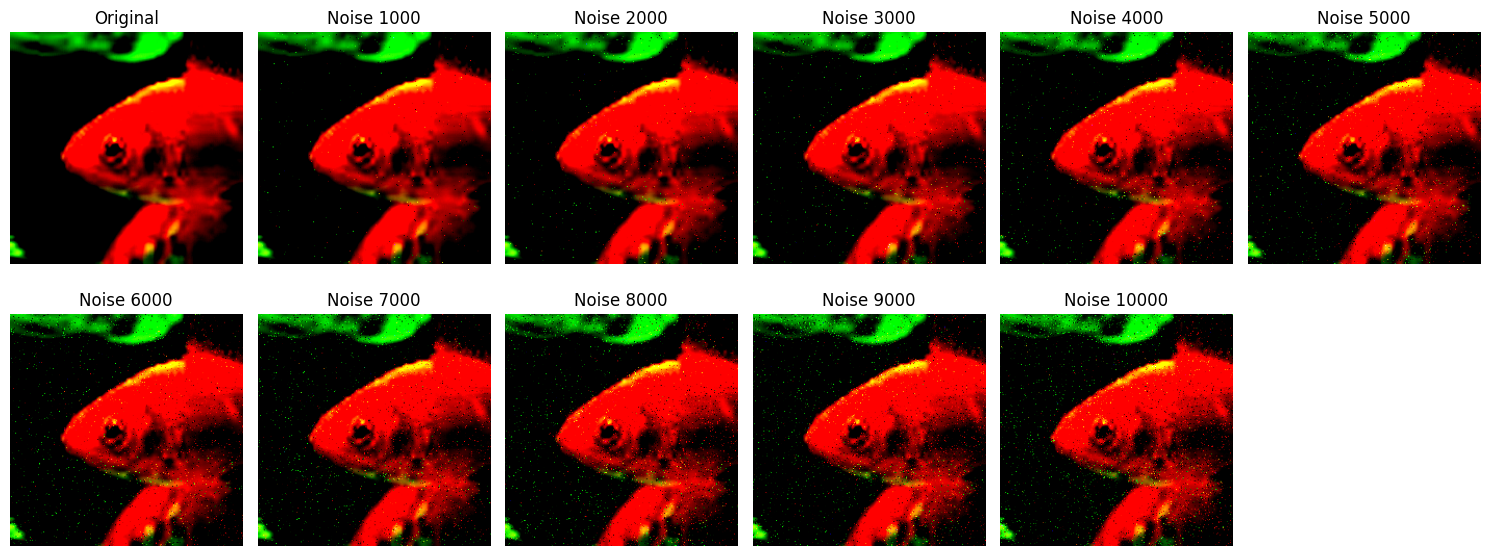

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader

def add_noise_to_random_pixels(image, num_noise_pixels=1000, noise_mean=0, noise_std=0.1):
    """
    Adds Gaussian noise to `num_noise_pixels` randomly selected pixels in the input image.
    
    Parameters:
    - image: numpy array of shape (H, W, C), values in [0, 1]
    - num_noise_pixels: number of pixels to alter
    - noise_std: standard deviation of the Gaussian noise
    
    Returns:
    - noisy_image: the image with noise added
    """
    H, W, C = image.shape
    noisy_image = image.copy()

    # Select random pixel locations
    pixel_indices = np.random.choice(H * W, size=num_noise_pixels, replace=False)
    rows = pixel_indices // W
    cols = pixel_indices % W

    # Add noise to each pixel across all 3 channels
    noisy_image[rows, cols, :] += np.random.normal(noise_mean, noise_std, size=(num_noise_pixels, C))

    # Optional: clip to valid range if needed (e.g., [0, 1] for image display)
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image

# --- Load test dataset and create DataLoader ---
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(test_loader))
i = 1

# Convert the i-th image to (H, W, C) format and to numpy
orig_image = images[i].permute(1, 2, 0).numpy()

# Plot original + noisy versions
# noise_levels = np.arange(0.1, 1.2, 0.1)  # 0.1 to 1.0 inclusive
# noise_levels = np.arange(0, 11, 1)  # 0.1 to 1.0 inclusive
noise_levels = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
num_levels = len(noise_levels)

plt.figure(figsize=(15, 6))

# Plot original
plt.subplot(2, 6, 1)
plt.imshow(orig_image)
plt.title("Original")
plt.axis('off')

# Plot noisy images
for idx, num_noise_pixels in enumerate(noise_levels, start=2):
    noise_image = add_noise_to_random_pixels(orig_image, num_noise_pixels=num_noise_pixels, noise_mean=0, noise_std=0.5)
    plt.subplot(2, 6, idx)
    plt.imshow(noise_image)
    plt.title(f"Noise {num_noise_pixels}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def fit_vision_model(
        model: torch.nn.Module = None,
        test_dataset: torch.utils.data.Dataset = None,
        batch_size: int = 32,
        shuffle: bool = False,
        tag: float = 0.0
    ) -> (np.array, np.array):
    """
    Fits a pre-trained vision model on the Tiny ImageNet test dataset.

    Parameters:
    - model: a pre-trained vision model (default: ResNet101)
    - test_dataset: a PyTorch dataset for the test data (default: None, will load from `test_path`)
    - batch_size: size of the batches for DataLoader (default: 32)
    - shuffle: whether to shuffle the dataset (default: False)

    Returns:
    - all_preds: numpy array of predicted labels (0-999)
    - all_targets: numpy array of ground truth labels (0-199)

    """

    # test dataset and create a batch loader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    # load pretrained ResNet101 (1,000 classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # prediction loop
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating Pre-trained Model with noise level {tag:.1f}", unit="batch"):
            images = images.to(device)
            outputs = model(images)

            # imagenet indices (0-999)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # remove samples whose class is not in imagenet 1k
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    return all_preds, all_targets


def translate_imagenet_to_tiny_imagenet_accuracy(
        all_preds: np.array,
        all_targets: np.array
    ) -> float:
    """
    Translates predictions from ImageNet classes to Tiny ImageNet classes
    and computes the accuracy.

    Parameters:
    - all_preds: numpy array of predicted labels (0-999)
    - all_targets: numpy array of ground truth labels (0-199)
    Returns:
    - accuracy: float, accuracy of predictions on Tiny ImageNet classes
    """
    import os
    import json
    
    src_file = os.path.join(data_path, "utils", "imagenet_class_index.json")
    with open(src_file, 'r') as f:
        imagenet_class_idx = json.load(f)
    tiny_imagenet_class_idx = test_dataset.class_to_idx

    # map tiny imagenet classes to imagenet WNIDs
    new_target = []
    new_preds = []
    for pred_idx, gt_idx in zip(all_preds, all_targets):
        # map predicted label (0–999) to WNID
        pred_wnid = imagenet_class_idx[str(pred_idx)][0]
        
        # map GT Tiny ImageNet label (already 0–199) to WNID
        gt_wnid = list(tiny_imagenet_class_idx.keys())[gt_idx]
        
        # only keep if pred is in Tiny ImageNet classes
        if pred_wnid in tiny_imagenet_class_idx:
            new_preds.append(tiny_imagenet_class_idx[pred_wnid])
            new_target.append(tiny_imagenet_class_idx[gt_wnid])

    new_preds = np.array(new_preds)
    new_target = np.array(new_target)

    acc = (new_preds == new_target).mean()
    
    return acc

def add_noise_to_random_pixels(
        image: torch.Tensor,
        num_noise_pixels: int = 1000,
        noise_std: float = 0.1
) -> torch.Tensor:
    """
    Adds Gaussian noise to a fixed number of random pixels in a (C,H,W) tensor image.

    Parameters
    ----------
    image : torch.Tensor
        Tensor of shape (C, H, W), normalized.
    num_noise_pixels : int, default=1000
        Number of pixels to modify with noise.
    noise_std : float, default=0.1
        Standard deviation of Gaussian noise.

    Returns
    -------
    torch.Tensor
        Noisy image tensor of shape (C, H, W).
    """
    C, H, W = image.shape
    noisy_image = image.clone()

    # Cap number of noisy pixels to image size
    num_noise_pixels = min(num_noise_pixels, H * W)

    # Random pixel indices
    pixel_indices = torch.randperm(H * W)[:num_noise_pixels]
    rows = pixel_indices // W
    cols = pixel_indices % W

    # Gaussian noise for all channels
    noise = torch.randn((num_noise_pixels, C), dtype=image.dtype) * noise_std
    noisy_image[:, rows, cols] += noise.T

    return noisy_image

def create_adversarial_dataset(
        dataset: torch.utils.data.Dataset,
        noise_fn: callable,
        **noise_kwargs
) -> torch.utils.data.Dataset:
    noisy_images = []
    labels = []

    for img_tensor, label in dataset:
        noisy_img = noise_fn(img_tensor, **noise_kwargs)
        noisy_images.append(noisy_img)
        labels.append(label)

    noisy_images = torch.stack(noisy_images)
    labels = torch.tensor(labels)

    return torch.utils.data.TensorDataset(noisy_images, labels)


In [ ]:
from torchvision import models, transforms
from torchvision import datasets

# relevant path for the test dataset
test_path = os.path.join(data_path, "inputs", "tiny-224", "test")

# define transformations of the images
transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   

])

# set noise levels
noise_levels = np.arange(0, 1.1, 0.1)
num_levels = len(noise_levels)

# Plot noisy images
for idx, noise_std in enumerate(noise_levels, start=2):
        
    # load the test dataset
    test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

    # load pre-trained model
    model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

    # add noise to the test dataset
    test_dataset_noisy = create_adversarial_dataset(
        dataset=test_dataset,
        noise_fn=add_noise_to_random_pixels,
        num_noise_pixels=1000,
        noise_std=noise_std
    )

    # Now fit_vision_model works
    all_preds, all_targets = fit_vision_model(
        model=model,
        test_dataset=test_dataset_noisy,
        batch_size=32,
        shuffle=False,
        tag=noise_std
    )

    # compute accuracy on Tiny ImageNet classes
    acc = translate_imagenet_to_tiny_imagenet_accuracy(all_preds, all_targets)
    print(f"Noise {noise_std:.1f} -> Test accuracy: {acc*100:.2f}%")

Evaluating Pre-trained Model with noise level 0.1: 100%|██████████| 157/157 [00:14<00:00, 10.96batch/s]


Noise 0.1 -> Test accuracy: 85.88%


Evaluating Pre-trained Model with noise level 0.2: 100%|██████████| 157/157 [00:13<00:00, 11.66batch/s]


Noise 0.2 -> Test accuracy: 86.08%


Evaluating Pre-trained Model with noise level 0.3: 100%|██████████| 157/157 [00:13<00:00, 11.71batch/s]


Noise 0.3 -> Test accuracy: 85.61%


Evaluating Pre-trained Model with noise level 0.4: 100%|██████████| 157/157 [00:13<00:00, 11.62batch/s]


Noise 0.4 -> Test accuracy: 85.56%


Evaluating Pre-trained Model with noise level 0.5: 100%|██████████| 157/157 [00:13<00:00, 11.58batch/s]


Noise 0.5 -> Test accuracy: 84.97%


Evaluating Pre-trained Model with noise level 0.6: 100%|██████████| 157/157 [00:14<00:00, 11.11batch/s]


Noise 0.6 -> Test accuracy: 84.15%


Evaluating Pre-trained Model with noise level 0.7: 100%|██████████| 157/157 [00:14<00:00, 11.17batch/s]


Noise 0.7 -> Test accuracy: 83.69%


Evaluating Pre-trained Model with noise level 0.8: 100%|██████████| 157/157 [00:14<00:00, 11.19batch/s]


Noise 0.8 -> Test accuracy: 83.70%


Evaluating Pre-trained Model with noise level 0.9: 100%|██████████| 157/157 [00:13<00:00, 11.44batch/s]


Noise 0.9 -> Test accuracy: 83.43%


Evaluating Pre-trained Model with noise level 1.0: 100%|██████████| 157/157 [00:13<00:00, 11.24batch/s]

Noise 1.0 -> Test accuracy: 83.48%
